<a href="https://colab.research.google.com/github/bibhashthapa7/CSCI-335-ML/blob/main/2025_spring/Week02_EDA/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the data

In [10]:
import pandas as pd
data = pd.read_csv('houses.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Assess and clean data

In [11]:
print(data.isnull().sum()) #check for missing values

print(data.info()) #check data types

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)


In [12]:
from sklearn.impute import SimpleImputer

#handle missing data by imputing using the median data of column
imputer = SimpleImputer(strategy='median')
data['total_bedrooms'] = imputer.fit_transform(data[['total_bedrooms']])

#verify no missing values
print(data.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


# Create features **X** and targets **y**


In [13]:
#separate features and target
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (20640, 9)
Shape of y: (20640,)


# Divide the dataset into training, validation, and testing sets

In [14]:
from sklearn.model_selection import train_test_split

#split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (12384, 9)
X_val shape: (4128, 9)
X_test shape: (4128, 9)


# Apply one-hot encoding to nominal columns

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#apply one-hot encoder to nominal column
transformer = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['ocean_proximity'])], remainder='passthrough')

#apply transformer to training, validation, and test sets
X_train_transformed = transformer.fit_transform(X_train)
X_val_transformed = transformer.transform(X_val)
X_test_transformed = transformer.transform(X_test)

#print shapes of transformed datasets
print("X_train_transformed shape:", X_train_transformed.shape)
print("X_val_transformed shape:", X_val_transformed.shape)
print("X_test_transformed shape:", X_test_transformed.shape)


X_train_transformed shape: (12384, 13)
X_val_transformed shape: (4128, 13)
X_test_transformed shape: (4128, 13)


# Train and validate KNeighborsRegressor


In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

#evaluate kNN for different k values
for k in range(1, 11):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_transformed, y_train)

    #validate the model
    y_val_pred = model.predict(X_val_transformed)
    mse = mean_squared_error(y_val, y_val_pred)
    print(f"k={k}, MSE={mse}")



k=1, MSE=16480944796.478924
k=2, MSE=12378794603.393047
k=3, MSE=11101584093.750593
k=4, MSE=10466359116.835514
k=5, MSE=10084572202.780958
k=6, MSE=9923480374.200037
k=7, MSE=9760793525.8745
k=8, MSE=9587172310.226202
k=9, MSE=9501723881.5199
k=10, MSE=9393188305.826618


Mean squared error (MSE) was chosen as the evaluation metric because it penalizes larger errors more heavily, which is useful for this problem as we want to minimize large deviations in housing price predictions

In [17]:
#based on validation MSE, k=10 is best value as it has the lowest MSE
best_k = 10

#train model with best k
final_model = KNeighborsRegressor(n_neighbors=best_k)
final_model.fit(X_train_transformed, y_train)

#test model
y_test_pred = final_model.predict(X_test_transformed)

#evaluate model on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE with k={best_k}: {test_mse}")

Test MSE with k=10: 9638641933.496479


# Modify transformation to apply scaling

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#add scaling to transformer
transformer_with_scaling = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), X_train.select_dtypes(include='number').columns),  #scale all numerical features
        ('onehot', OneHotEncoder(), ['ocean_proximity'])  #one-hot encode nominal features
    ],
    remainder='passthrough'  #leep other columns unchanged
)

#transform the datasets with scaling
X_train_scaled = transformer_with_scaling.fit_transform(X_train)
X_val_scaled = transformer_with_scaling.transform(X_val)
X_test_scaled = transformer_with_scaling.transform(X_test)

print("Scaled X_train shape:", X_train_scaled.shape)
print("Scaled X_val shape:", X_val_scaled.shape)
print("Scaled X_test shape:", X_test_scaled.shape)

Scaled X_train shape: (12384, 13)
Scaled X_val shape: (4128, 13)
Scaled X_test shape: (4128, 13)


# Train and validate kNN with scaling

In [20]:
#evaluate kNN with scaling for different k values
for k in range(1, 11):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_scaled, y_train)

    #validate the model
    y_val_pred_scaled = model.predict(X_val_scaled)
    mse_scaled = mean_squared_error(y_val, y_val_pred_scaled)
    print(f"k={k}, Validation MSE (With Scaling): {mse_scaled}")


k=1, Validation MSE (With Scaling): 5871953947.570495
k=2, Validation MSE (With Scaling): 4676188924.391473
k=3, Validation MSE (With Scaling): 4254359309.203461
k=4, Validation MSE (With Scaling): 4016749797.894047
k=5, Validation MSE (With Scaling): 3883078068.4664345
k=6, Validation MSE (With Scaling): 3869018840.403067
k=7, Validation MSE (With Scaling): 3815999031.3935843
k=8, Validation MSE (With Scaling): 3778027062.252801
k=9, Validation MSE (With Scaling): 3758060565.413724
k=10, Validation MSE (With Scaling): 3747548440.5510783


In [21]:
best_k_scaled = 10

final_model_scaled = KNeighborsRegressor(n_neighbors=best_k_scaled)
final_model_scaled.fit(X_train_scaled, y_train)

y_test_pred_scaled = final_model_scaled.predict(X_test_scaled)

test_mse_scaled = mean_squared_error(y_test, y_test_pred_scaled)
print(f"Test MSE with Scaling (k={best_k_scaled}): {test_mse_scaled}")

Test MSE with Scaling (k=10): 3833444108.043442


# Compare results

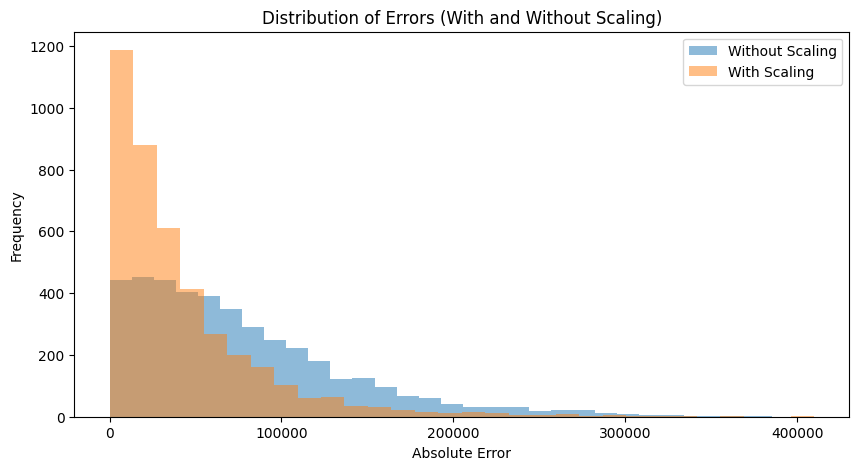

In [22]:
import numpy as np
import matplotlib.pyplot as plt

#calculate absolute errors
errors_without_scaling = np.abs(y_test - y_test_pred)
errors_with_scaling = np.abs(y_test - y_test_pred_scaled)

#plot histograms of errors
plt.figure(figsize=(10, 5))
plt.hist(errors_without_scaling, bins=30, alpha=0.5, label="Without Scaling")
plt.hist(errors_with_scaling, bins=30, alpha=0.5, label="With Scaling")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Errors (With and Without Scaling)")
plt.show()

After analyzing the results, the model with scaling performed better than the one without scaling. This is shown by the lower test MSE and a more concentrated error distribution near zero in the histogram.

This may because kNN relies on distance metric and scaling ensures all the features contribute equally, preventing features with larger ranges from dominating. Without scaling, the model produces larger errors, likely due to unequal feature contributions.


# Writing assignment

**Difference between supervised and unsupervised problems:**

- Supervised problems: In supervised learning, the data has labels. This means we have input data (features) and the correct output (target). The model learns to predict the output from the input.

- Unsupervised problems: n unsupervised learning, the data does not have labels. The model finds patterns or groups in the data without being told what the correct output is.

**What is the purpose of splitting data into training, validation, and testing sets? What is a typical split-up?**

- Training set: Used to teach the model patterns in the data.
- Validation set: Used to tune the model's parameters and avoid overfitting.
- Testing set: Used to evaluate how well the model performs on unseen data

Typical split: 60-80% for training, 10-20% for validation and 10-20% for testing.